## Stochastic Gradient Ascent

The goal of this notebook is to implement a logistic regression classifier using stochastic gradient ascent.

 * Extract features from Amazon product reviews.
 * Convert an DataFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with respect to a single coefficient.
 * Implement stochastic gradient ascent.
 * Compare convergence of stochastic gradient ascent with that of batch gradient ascent.

In [23]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Load and process review dataset

For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

In [24]:
products = pd.read_csv('amazon_baby_subset.csv')

In [26]:
with open('important_words.json') as important_words_file:    
    important_words = json.load(important_words_file)
print(important_words[:3])

['baby', 'one', 'great']


Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string manipulation functionality.
2. Compute word counts (only for the important_words)

Refer to Module 3 assignment for more details.

In [27]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

def remove_punctuation(text):
    import string
    return text.translate(text.maketrans("","",string.punctuation)) 

products['review_clean'] = products['review'].apply(remove_punctuation)
products.head(3)

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...


In [29]:
from tqdm  import tqdm
important_words=pd.read_json("important_words.json")
important_words=list(important_words[0])
for word in tqdm(important_words):
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))
    #print(word)


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [01:22<00:00,  2.34it/s]


The SFrame **products** now contains one column for each of the 193 **important_words**. 

In [30]:
products['perfect'][:3]

0    0
1    0
2    0
Name: perfect, dtype: int64

In [31]:
products.head(2)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split data into training and validation sets

We will now split the data into a 90-10 split where 90% is in the training set and 10% is in the validation set. We use `seed=1` so that everyone gets the same result.

In [33]:
train_json=pd.read_json("module-10-assignment-train-idx.json")
validation_json=pd.read_json("module-10-assignment-validation-idx.json")
train_data=products.iloc[train_json[0]]
validation_data=products.iloc[validation_json[0]]

In [35]:
train_data.head(2)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
validation_data.head(2)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
9,Cloth Diaper Pins Stainless Steel Traditional ...,It has been many years since we needed diaper ...,5,1,It has been many years since we needed diaper ...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,Neurosmith - Music Blocks with Mozart Music Ca...,My daughter started playing with her Music Blo...,5,1,My daughter started playing with her Music Blo...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
print('Training set  : %d data points' % len(train_data))
print ('Validation set: %d data points' % len(validation_data))

Training set  : 47780 data points
Validation set: 5292 data points


## Convert DFrame to NumPy array

Just like in the earlier assignments, we provide you with a function that extracts columns from an DFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [41]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.to_numpy()
    label_sarray = dataframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [43]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

<ipython-input-41-9cef56106022>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['constant'] = 1


In [45]:
print(feature_matrix_train.shape)
print(feature_matrix_valid.shape)

(47780, 194)
(5292, 194)


Note that we convert both the training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

## Building on logistic regression

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 



In [46]:
'''
feature_matrix: N * D(intercept term included)
coefficients: D * 1
predictions: N * 1
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''

def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients) # N * 1
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1.0/(1+np.exp(-score))
    
    # return predictions
    return predictions

## Derivative of log likelihood with respect to a single coefficient

Let us now work on making minor changes to how the derivative computation is performed for logistic regression.

Recall from the lectures and Module 3 assignment that for logistic regression, **the derivative of log likelihood with respect to a single coefficient** is as follows:

$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

In Module 3 assignment, we wrote a function to compute the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts the following two parameters:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 
Complete the following code block:

In [47]:
"""
errors: N * 1
feature: N * 1
derivative: 1 
"""
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(np.transpose(errors), feature)
    # Return the derivative
    return derivative

**Note**. We are not using regularization in this assignment, but, as discussed in the optional video, stochastic gradient can also be used for regularized logistic regression.

To verify the correctness of the gradient computation, we provide a function for computing average log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

To track the performance of stochastic gradient ascent, we provide a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

**Note** that we made one tiny modification to the log likelihood function (called **compute_log_likelihood**) in our earlier assignments. We added a $\color{red}{1/N}$ term which averages the log likelihood accross all data points. The $\color{red}{1/N}$ term makes it easier for us to compare stochastic gradient ascent with batch gradient ascent. We will use this function to generate plots that are similar to those you saw in the lecture.

In [48]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    # scores.shape (53072L, 1L)
    # indicator.shape (53072L,)
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum( ( indicator.reshape(scores.shape)-1 )*scores - logexp )/len(feature_matrix)   
    
    return lp

the log likelihood (without the averaging term) is given by 

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$



## Modifying the derivative for stochastic gradient ascent

Recall from the lecture that the gradient for a single data point $\color{red}{\mathbf{x}_i}$ can be computed using the following formula:

$$
\frac{\partial\ell_{\color{red}{i}}(\mathbf{w})}{\partial w_j} = h_j(\color{red}{\mathbf{x}_i})\left(\mathbf{1}[y_\color{red}{i} = +1] - P(y_\color{red}{i} = +1 | \color{red}{\mathbf{x}_i}, \mathbf{w})\right)
$$


** Computing the gradient for a single data point**

Do we really need to re-write all our code to modify $\partial\ell(\mathbf{w})/\partial w_j$ to $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$? 


Thankfully **No!**. Using NumPy, we access $\mathbf{x}_i$ in the training data using `feature_matrix_train[i:i+1,:]`
and $y_i$ in the training data using `sentiment_train[i:i+1]`. We can compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ by re-using **all the code** written in **feature_derivative** and **predict_probability**.


We compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ using the following steps:
* First, compute $P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ using the **predict_probability** function with `feature_matrix_train[i:i+1,:]` as the first parameter.
* Next, compute $\mathbf{1}[y_i = +1]$ using `sentiment_train[i:i+1]`.
* Finally, call the **feature_derivative** function with `feature_matrix_train[i:i+1, j]` as one of the parameters. 

Let us follow these steps for `j = 1` and `i = 10`:

In [50]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions        
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print("Gradient single data point: %s" % gradient_single_data_point)
print ("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


## Modifying the derivative for using a batch of data points

Stochastic gradient estimates the ascent direction using 1 data point, while gradient uses $N$ data points to decide how to update the the parameters.  In an optional video, we discussed the details of a simple change that allows us to use a **mini-batch** of $B \leq N$ data points to estimate the ascent direction. This simple approach is faster than regular gradient but less noisy than stochastic gradient that uses only 1 data point. Although we encorage you to watch the optional video on the topic to better understand why mini-batches help stochastic gradient, in this assignment, we will simply use this technique, since the approach is very simple and will improve your results.

Given a mini-batch (or a set of data points) $\mathbf{x}_{i}, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$, the gradient function for this mini-batch of data points is given by:
$$
\color{red}{\sum_{s = i}^{i+B}} \frac{\partial\ell_{s}}{\partial w_j} = \color{red}{\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$


** Computing the gradient for a "mini-batch" of data points**

Using NumPy, we access the points $\mathbf{x}_i, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$ in the training data using `feature_matrix_train[i:i+B,:]`
and $y_i$ in the training data using `sentiment_train[i:i+B]`. 

We can compute $\color{red}{\sum_{s = i}^{i+B}} \partial\ell_{s}/\partial w_j$ easily as follows:

In [51]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions        
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print("Gradient mini-batch data points: %s" % gradient_mini_batch)
print("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


### Averaging the gradient across a batch

It is a common practice to normalize the gradient update rule by the batch size B:

$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
In other words, we update the coefficients using the **average gradient over data points** (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of **all the data points**), and study the effect of batch size on the algorithm as well as the choice of step size.


## Implementing stochastic gradient ascent

Now we are ready to implement our own logistic regression with stochastic gradient ascent. Complete the following function to fit a logistic regression model using gradient ascent:

In [55]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:(i+batch_size),:], coefficients)

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i:i+batch_size]==+1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j]) 
                  # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += step_size * derivative * 1. / batch_size

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print('Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))  

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

**Note**. In practice, the final set of coefficients is rarely used; it is better to use the average of the last K sets of coefficients instead, where K should be adjusted depending on how fast the log likelihood oscillates around the optimum.

### Checkpoint


The following cell tests your stochastic gradient ascent function using a toy dataset consisting of two data points. If the test does not pass, make sure you are normalizing the gradient update rule correctly.

In [56]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3), step_size=1., batch_size=2, max_iter=2)
print('-------------------------------------------------------------------------------------')
print( 'Coefficients learned                 :', coefficients)
print ('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print('-------------------------------------------------------------------------------------')
    print('Test passed!')
else:
    print ('-------------------------------------------------------------------------------------')
    print ('Test failed')

Iteration 0: Average log likelihood (of data points  [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points  [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


## Running gradient ascent using the stochastic gradient ascent implementation

Instead of implementing batch gradient ascent separately, we save time by re-using the stochastic gradient ascent function we just wrote &mdash; **to perform gradient ascent**, it suffices to set **`batch_size`** to the number of data points in the training data. Yes, we did answer above the quiz question for you, but that is an important point to remember in the future :)

**Small Caveat**. The batch gradient ascent implementation here is slightly different than the one in the earlier assignments, as we now normalize the gradient update rule.

We now **run stochastic gradient ascent** over the **feature_matrix_train** for 10 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = 1`
* `max_iter = 10`

In [57]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                        initial_coefficients=np.zeros(194),\
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


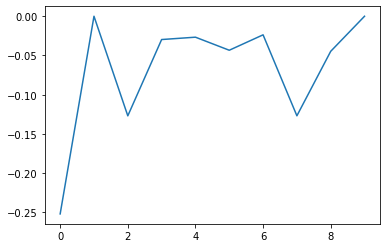

In [58]:
plt.plot(log_likelihood)
plt.show()

Now run **batch gradient ascent** over the **feature_matrix_train** for 200 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = len(feature_matrix_train)`
* `max_iter = 200`

In [60]:
# YOUR CODE HERE
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

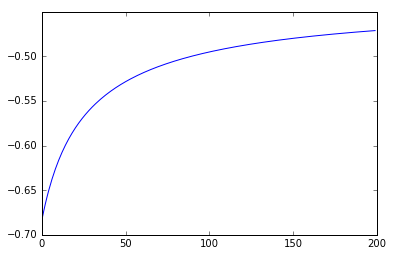

In [52]:
plt.plot(log_likelihood_batch)
plt.show()

**Quiz Question**. When you set `batch_size = len(feature_matrix_train)`, as each iteration passes, how does the average log likelihood in the batch change?
* Increases 
* Decreases
* Fluctuates 

## Make "passes" over the dataset

To make a fair comparison betweeen stochastic gradient ascent and batch gradient ascent, we measure the average log likelihood as a function of the number of passes (defined as follows):
$$
[\text{# of passes}] = \frac{[\text{# of data points touched so far}]}{[\text{size of dataset}]}
$$

## Log likelihood plots for stochastic gradient ascent

With the terminology in mind, let us run stochastic gradient ascent for 10 passes. We will use
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [65]:
step_size = 1e-1
batch_size = 10
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

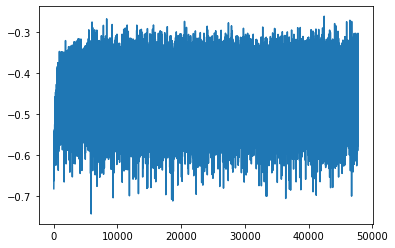

In [67]:
plt.plot(log_likelihood_sgd)
plt.show()

In [61]:
def draw_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

No handles with labels found to put in legend.


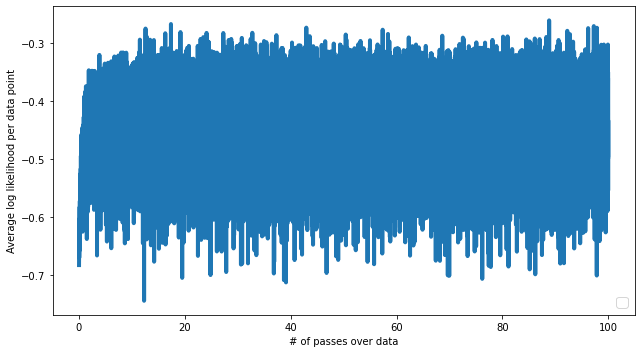

In [69]:
draw_plot(log_likelihood_sgd,len_data=len(feature_matrix_train),batch_size=100)

## Smoothing the stochastic gradient ascent curve

The plotted line oscillates so much that it is hard to see whether the log likelihood is improving. In our plot, we apply a simple smoothing operation using the parameter `smoothing_window`. The smoothing is simply a [moving average](https://en.wikipedia.org/wiki/Moving_average) of log likelihood over the last `smoothing_window` "iterations" of  stochastic gradient ascent.

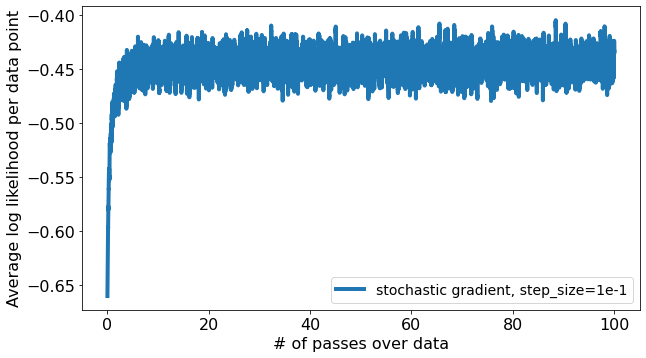

In [71]:
draw_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

**Checkpoint**: The above plot should look smoother than the previous plot. Play around with `smoothing_window`. As you increase it, you should see a smoother plot.

## Stochastic gradient ascent vs batch gradient ascent

To compare convergence rates for stochastic gradient ascent with batch gradient ascent, we call `make_plot()` multiple times in the same cell.

We are comparing:
* **stochastic gradient ascent**: `step_size = 0.1`, `batch_size=100`
* **batch gradient ascent**: `step_size = 0.5`, `batch_size=len(feature_matrix_train)`

Write code to run stochastic gradient ascent for 200 passes using:
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [72]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

## YOUR CODE HERE
coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

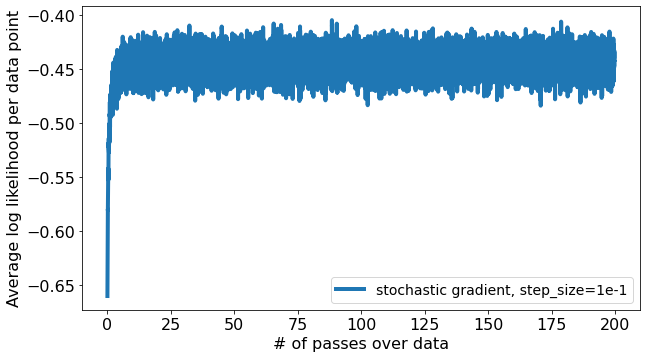

In [73]:
draw_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

In [74]:
# YOUR CODE HERE
step_size = 1e-1
batch_size = 100
num_passes = 20
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                        initial_coefficients=np.zeros(194),\
                                        step_size=5e-1, batch_size=len(feature_matrix_train),max_iter=200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

We compare the convergence of stochastic gradient ascent and batch gradient ascent in the following cell. Note that we apply smoothing with `smoothing_window=30`.

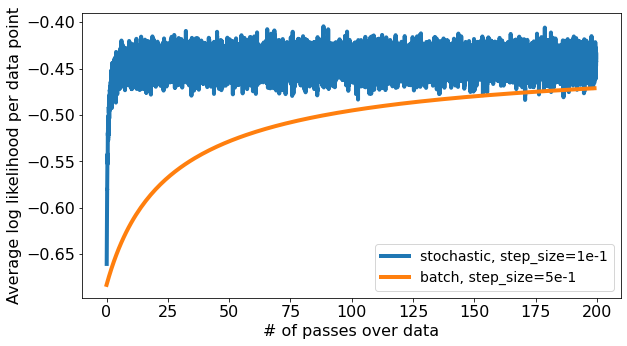

In [76]:
draw_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
draw_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

**Quiz Question**: In the figure above, how many passes does batch gradient ascent need to achieve a similar log likelihood as stochastic gradient ascent? 

1. It's always better
2. 10 passes
3. 20 passes
4. 150 passes or more

## Explore the effects of step sizes on stochastic gradient ascent

In previous sections, we chose step sizes for you. In practice, it helps to know how to choose good step sizes yourself.

To start, we explore a wide range of step sizes that are equally spaced in the log space. Run stochastic gradient ascent with `step_size` set to 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, and 1e2. Use the following set of parameters:
* `initial_coefficients=np.zeros(194)`
* `batch_size=100`
* `max_iter` initialized so as to run 10 passes over the data.

In [77]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                       initial_coefficients=np.zeros(194),\
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

Iteration  200: Average log likelihood (of data points  [20000:20100]) = -0.54566060
Iteration  300: Average log likelihood (of data points  [30000:30100]) = -0.48245740
Iteration  400: Average log likelihood (of data points  [40000:40100]) = -0.46629313
Iteration  500: Average log likelihood (of data points  [02300:02400]) = -0.47223389
Iteration  600: Average log likelihood (of data points  [12300:12400]) = -0.52216798
Iteration  700: Average log likelihood (of data points  [22300:22400]) = -0.52336683
Iteration  800: Average log likelihood (of data points  [32300:32400]) = -0.46963453
Iteration  900: Average log likelihood (of data points  [42300:42400]) = -0.47883783
Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -0.46988191
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -0.46365531
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -0.36466901
Iteration 4000: Average log likelihood (of data points  [18400:18

<ipython-input-48-e4f728168770>:5: RuntimeWarning: overflow encountered in exp
  logexp = np.log(1. + np.exp(-scores))


Iteration  200: Average log likelihood (of data points  [20000:20100]) = -4.03607476
Iteration  300: Average log likelihood (of data points  [30000:30100]) = -5.77153013


<ipython-input-46-eab2209dbf34>:16: RuntimeWarning: overflow encountered in exp
  predictions = 1.0/(1+np.exp(-score))


Iteration  400: Average log likelihood (of data points  [40000:40100]) = -4.59158191
Iteration  500: Average log likelihood (of data points  [02300:02400]) = -11.55143232
Iteration  600: Average log likelihood (of data points  [12300:12400]) = -7.84116101
Iteration  700: Average log likelihood (of data points  [22300:22400]) = -9.04283314
Iteration  800: Average log likelihood (of data points  [32300:32400]) = -4.69671208
Iteration  900: Average log likelihood (of data points  [42300:42400]) = -4.28524797
Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -4.54798564
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -18.25204800
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -1.83420591
Iteration 4000: Average log likelihood (of data points  [18400:18500]) = -23.70968569
Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -21.99879315


### Plotting the log likelihood as a function of passes for each step size

Now, we will plot the change in log likelihood using the `make_plot` for each of the following values of `step_size`:

* `step_size = 1e-4`
* `step_size = 1e-3`
* `step_size = 1e-2`
* `step_size = 1e-1`
* `step_size = 1e0`
* `step_size = 1e1`
* `step_size = 1e2`

For consistency, we again apply `smoothing_window=30`.

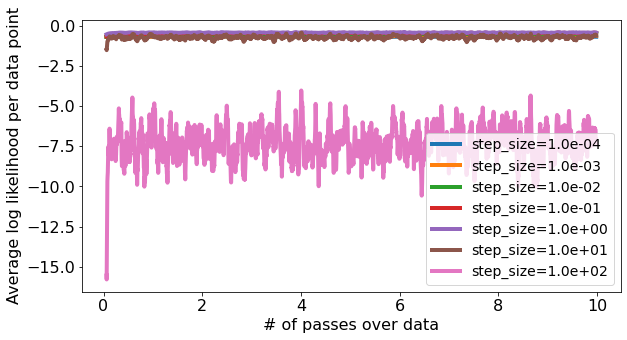

In [79]:
for step_size in np.logspace(-4, 2, num=7):
    draw_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

Now, let us remove the step size `step_size = 1e2` and plot the rest of the curves.

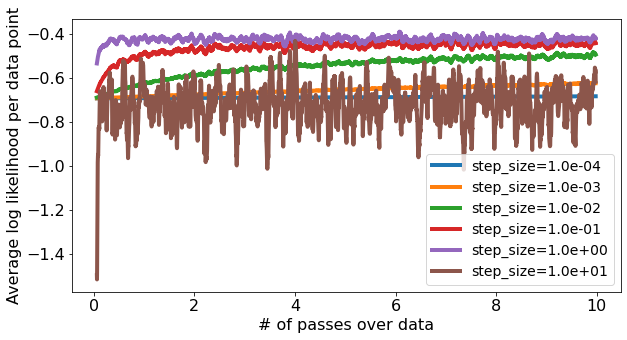

In [81]:
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    draw_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)